# Table of contents
1. [Purpose](#purpose)
2. [Evaluation Metrics](#metrics)
3. [Inputs](#inputs)
    * [3.1 Occurrence Filters Database](#subinput1)
    * [3.2 Point Occurrence Database](#subinput2)
    * [3.3 GAP Species Habitat Maps](#subinput3)
4. [Outputs](#outputs)
5. [Constraints](#constraints)
6. [Dependencies](#dependencies)
    * [5.1 Code Language](#codelanguage)
      * [5.1.1 package requirements](#packagerequirements)

7. [Code](#code)
    * [6.1 Python Package Import](#code61)
    * [6.2 Connect to SQLite Database of Species Occurrences](#code62)
    * [6.3 Looping Over Point Buffers to Mask Species Raster](#code63)
    * [6.4 Make Dataframe for Buffer Proportion Assessment (BPA)](#code64)
    * [6.5 Make Dataframe for Buffer Sensitivity Metric (BSM)](#code65)
    * [6.6 Buffer Proportion Assessment Plot](#code66)
    * [6.6 Buffer Sensitivity Metric Plot](#code67)

8. [Discussion](#discussion)

9. [Citations](#citations)

---

# Evaluating GAP Habitat Maps Using Presence-only Occurrence Data
<br/>

## Purpose <a name="purpose"></a>
Model generated maps of suitable species’ habitat to aid biodiversity conservation need to be evaluated for utility to end users and to inform future modeling in a quantitative way. Recently, species location data repositories with enormous numbers of records (i.e. billions) have become ubiquitously available online allowing rapid programmatic access through application interfaces (APIs). However, these location occurrence datasets are usually gathered opportunistically (i.e. museum records, citizen science efforts) and therefore only represent species presence and not absence. Presence-only data are problematic because they eliminate the use of confusion matrix-based metrics such as Kappa that discriminate between where species or habitats **are**  and **are not** located. Additionally, many of these occurrences are not georeferenced, that is, they have no spatial information such as longitude and latitude (x, y). When records do have x-y locations, they often either lack information regarding their spatial accuracy or the accuracy is very low (e.g. >5 km). Points with such high positional uncertainty are only directly comparable to model outputs of similar scale/resolution.

The U.S. Geological Survey Gap Analysis Project (GAP) focuses on modeling species habitat distributions for all terrestrial vertebrates in the US. Model outputs are binary habitat maps (suitable/unsuitable) created at a relatively fine resolution (30 meters)(McKerrow et al. 2018). We developed two evaluation methods that incorporate presence-only point occurrence records and their locational uncertainty to assess habitat maps at their native resolution. These metrics avoid either removing large numbers of occurrences because of low accuracy and/or “enlarging” map resolution to match greater numbers of records. The first, buffer proportion, is based on the proportion of habitat in the range relative to mean proportion of habitat around each occurrence record. It is a modification of Rondinini et al.’s (2011) model prevalence vs. point prevalence metric. The second measures true presence fraction (sensitivity) at varying distances from occurrences. This notebook illustrates the workflow used to compile and filter species occurrence records from on-line resources (e.g. [Global Biodiversity Information Facility](https://www.gbif.org/) and [Biodiversity Serving Our Nation](https://bison.usgs.gov/#home)).

## Evaluation Metrics <a name="metrics"></a>
### Buffer Proportion Assessment (BPA)
Rondinini et al. (2011) created deductive habitat suitability models (high, medium, unsuitable) for >5000 terrestrial mammals globally at a spatial grain of 300 meters to examine patterns of richness and protection. They conducted model evaluation on a subset of only 263 species because detailed occurrence data are lacking for most mammal taxa. The occurrence data used contains information on species presence only, limiting assessment methodologies. Therefore, Rondinini et al. chose to compare what they term ‘model prevalence’ and ‘point prevalence’ to species’ landscapes of randomly distributed habitat at a spatial grain of 1 km2 (the assumed accuracy of their point locality data). Point prevalence is defined as the proportion of 1 km2 cells containing one or more occurrences and one or more 300 m cells with high and/or medium suitability (i.e. proportion of correctly predicted occurrences). Model prevalence is defined as the proportion of 1 km2 cells with high or medium suitability within the species’ range. As they describe: “If predicted suitable cells were distributed randomly with respect to species occurrences, the expectation would be that the point prevalence equals the model prevalence.” Hence, the comparison assumes a random habitat landscape is one in which any given location contains habitat at proportions equal to model predicted habitat across the entire species’ range. When point prevalence is greater than model prevalence, the model predicts habitat at species locations better than the range “because it tends to correctly flag as unsuitable the cells that do not contain occurrences.”

GAP species maps include geographic range along with distribution of potential habitat generated at a spatial raster resolution of 30 meters. Therefore, each species has a measurement of model prevalence, which is simply the areal proportion of predicted habitat within the delineated range. However, in order to calculate point prevalence at a 30 meter spatial grain, point occurrences would need to have an equivalent spatial accuracy. Point prevalence calculations at a 30 meter spatial grain will be available only for a very limited number of species and with very few data points because most point occurrence datasets (e.g. GBIF, BiSON, eBird) have either no information regarding individual location accuracy or vary widely in coordinate uncertainty (e.g. <100 m to province-level centroids). However, buffering point occurrences by the degree of uncertainty of presence locations and calculating the proportion of habitat within those buffers would allow for comparisons to random habitat landscapes using range alone. As with point prevalence vs. model prevalence, models that predict habitat better than random would have a mean proportion of habitat in point buffers greater than the proportion of habitat throughout the species’ range.
<img src="BPAGraphic.png">

### Buffer Sensitivity Metric (BSM)
Since occurrence points have varying amounts of uncertainty associated with their geographic location, comparing them with the habitat map will result in a varying degree of assessment. Illustrating this variation across a number of scales can help model users determine which scale is most suitable for their intended use. The accuracy assessment measure ‘sensitivity’ is also referred to as the true positive fraction in model validation. For habitat map assessment, it is a measure of locations correctly predicted to be habitat. Sensitivity is calculated as the count of true positives divided by the sum of true positive plus false negative counts:

$$\displaystyle Sensitivity = \frac{True Positive}{True Positive+False Negative}$$

Using occurrence points in GAP habitat map evaluation, a true positive is recorded when at least one predicted habitat cell occurs within an occurrence point uncertainty buffer. A false negative is recorded when no habitat cells occur within an occurrence point buffer because occurrence points only record presence of a species and not absence. A sensitivity measure can be calculated for increasing buffer distances (i.e. scales) where a cumulative count of true positive (at least one habitat cell) and false negative (no habitat cells) are made for buffer sizes less than or equal to one of several size categories (for example 30, 100, 500, 1000, 2000, 5000, and 10000 meters). High sensitivity is indicative of a low omission rate or false positive fraction because sensitivity and omission rate sum to one.

#### Statistical significance tests
A map of randomly distributed habitat would be equal in proportion to the model predicted proportion of habitat within the species range. Models better than random will predict habitat adjacent to species locations at proportions greater than proportions throughout the range. Statistical significance tests can be made comparing the sensitivity (omission rate) to the model prevalence (proportion of habitat in the species range) using an exact one-sided binomial test (Anderson et al. 2002, Pearson 2007). Since sensitivity can be calculated for each buffer distance category, a test can be performed for each category.

#### Note
The rule wherein an occurrence location is counted as a true positive for habitat if at least one cell is within the point buffer could be altered to increase stringency. Any arbitrary value such as at least 15% of the buffer area could be used for all species or the threshold could be species specific such as the percentage of habitat predicted within the range.


## Inputs <a name="inputs"></a>
The code in this notebook illustrates a workflow for a quantitative evaluation of model derived binary habitat maps. The independent data utilized are presence-only occurrence records acquired from online data repositories/aggregators such as the Global Biodiversity Information Facility [(GBIF)](https://www.gbif.org/). In order for these datasets to be useful for analyses such as habitat map evaluation, occurrence records need "cleaning" to address issues like duplication, date range, spatial inaccuracies, taxonomic changes and uncertainty, etc. A framework has been developed using Python and Jupter Notebooks (currently dubbed [The Wildlife Wrangler](https://github.com/nmtarr/wildlife-wrangler)) that attempts to address such complex issues when downloading and organizing occurrence records using automated, transparent, and reproducible methods. A major component of the framework are open source, [SQLite](https://www.sqlite.org/index.html) databases that store both user defined filtering criteria and the downloaded occurrence records themselves. 


* **Occurrence Filters Database** <a name="subinput1"></a><br/>
A SQLite database locally available that stores all filtering information supplied by the user.

* **Point Occurrence Database** <a name="subinput2"></a><br/>
A SQLite database generated and stored locally that houses downloaded and filter occurrence records and their spatial geometries. One database is generated for each species and its associated occurrence records.

* **GAP Species Habitat Maps** <a name="subinput3"></a><br/>
Binary habitat maps in raster (GeoTIFF) format stored locally. Cell values must be **$\geq 1$** indicating suitable habitat, and **$0$** indicating unsuitable habitat.



## Outputs <a name="outputs"></a>

* [Buffer Proportion Assessment Scatterplot:](#BPA)
This chart visualizes the comparisons between the proportion of habitat in a species range and the mean proportion of habitat with buffered point occurrences. Values above the x=y line indicate modeled habitat is **'better than random'** at predicting habitat at species locations across the species' range; while values below the x=y line indicate a model that is **'worse than random'** at predicting suitable habitat at species point occurrence locations.


* [Buffer Sensitivity Metric Chart:](#BSM)
This chart visualizes the Sensitivity measure for each of several buffer distance categories along with stacked bars showing the number of point occurrences and the number of True Positives. P-values for exact one-sided binomial tests comparing true positive fraction to model prevalence are indicated above each buffer category.

## Constraints <a name="constraints"></a>
Habitat mapping constraints. See user constraints section on the USGS ScienceBase [GAP Species Habitat Maps](https://www.sciencebase.gov/catalog/item/527d0a83e4b0850ea0518326) page

## Dependencies <a name="dependencies"></a>
Code execution and output visualization dependencies

* **Code Language** <a name="codelanguage"></a>  
This code was written uing Python 3.6.5. Earlier versions may be compatible given slight alterations in syntax and package components.
  * **Python package requirements** <a name="packagerequirements"></a>  
  The required packages for proper code execution inlclude:
    - Pandas version 1.0x or above
    - GeoPandas version 0.4x or above
    - numpy version 1.18.x or above
    - SQLite3 version 3.31.x or above
    - Scipy (scientific library) version 1.4x or above
    - matplotlib (figures library) version 3.1.x or above
    - RasterIO (geospatial raster dataset package) version 1.1 or above
    - GDAL (geospatial data abstraction library) version 3.0 or above
    - LibTIFF (Tiff read/write library) version 4.1 or above


## Code <a name="code"></a>

### Import required Python packages <a name="code61"></a>

In [1]:
import rasterio
import rasterio.mask
from shapely.geometry import mapping
import sqlite3
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime
import math
from scipy import stats
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)

t0 = datetime.now()

### Setup directory locations and species specific variables 

In [2]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#            ++++ Directory Locations ++++
#
# Macbook specific
workDir = '/Users/matthewrubino/GAP-Habitat-Map-Assessment/'
# Windows specific
#workDir = "D:/USGS Analyses/GAP-Habitat-Map-Assessment/"
dbDir = workDir + 'db/'
sppDir = workDir + 'species/'

# The variable prophab is the proportion of habitat in the species range estimated
# by the habitat model. It is compared with the mean proportion of habitat within
# point buffers - BPA. It is also used in a binomial test of each buffer distance
# sensitivity measurement (true positive fraction) of occurrence points with at
# least one (or >= proportion habitat in range threshold) habitat cell within the
# coordinate uncertainty buffer area - BSM
sppcode = 'aMASAx'
prophab = 0.159
# Suitable habitat raster value
# For original GAP habitat map rasters values are seasonal:
#  1 = summer only
#  2 = winter only
#  3 = year-round
# NOTE: these values could be altered to just 1s if all seasons are used
habval = 1

### Make a variable for the GAP species habitat map

In [3]:
# This TIF raster is a 0-1 species habitat map. It assumes that all habitat
# cells in the raster are 1s and all non-habitat cells are 0s. If different
# habitat TIFs are used, the code will need to be altered.
HabMap = sppDir + f'{sppcode}_CONUS_01A_2001v1.tif'
#HabMap = sppDir + '{0}_CONUS_HabMap_2001v1.tif'.format(sppcode)

In [4]:
print('\nWorking on the Following Species Code:',sppcode)
print('\n  Opening Point Buffer Geometries into a GeoPandas Dataframe ....')


Working on the Following Species Code: aMASAx

  Opening Point Buffer Geometries into a GeoPandas Dataframe ....


### Connect to the species SQLite db generated by the Wrangler and get necessary columns from the occurrences table. This will pull out 4 columns:
   * **occ_id**
   * **latitude**
   * **longitude**
   * **coordinateUncertaintyInMeters**

### Then generate a GeoPandas dataframe from latitude-longitude coordinates and buffers these point using the coordinate uncertainty column as the buffer distance in meters. <a name="code62"></a>

In [5]:
'''
 This uses a point buffer shapefile as the data source

# Open the point buffer shapefile with GeoPandas
gdfPtBuffs = gpd.read_file(shpBuff)
# Extract the geometries in GeoJSON format
geoms = gdfPtBuffs.geometry.values
'''

'''
 This opens a GeoPandas Dataframe directly from a SQLite db
 located in the workDir/db directory and pulls out 4 columns
 from the 'occurrences' table:
   occ_id,
   longitude,
   latitude,
   coordinateUncertaintyInMeters
 A geometery column is created using each record's latitude and longitude
 and then resets the CRS from WGS84 (EPSG:4326) to Albers EA (EPSG:5070)
 Another column is created (buff_dist) to set buffer distance for each point
 with a minimum of 30 meters based on coordinate uncertainty.
'''

db = dbDir + f"{sppcode}.sqlite"
conn = sqlite3.connect(db, isolation_level='DEFERRED')
# Bring the occurrence id, latitude and longitude, and coordinate uncertainty
# in the species SQLite db into a Pandas dataframe
# Set the column data types using a dictionary
dtdict = {'occ_id':'str','longitude':'float','latitude':'float',
          'coordinateUncertaintyInMeters':'int16'} 

df = pd.read_sql_query("SELECT occ_id, longitude, latitude, \
                        coordinateUncertaintyInMeters FROM occurrences", conn)

dfPts = df.astype(dtdict)

# Bring the lat-longs into a geometry for GeoPandas
gdf = gpd.GeoDataFrame(dfPts, geometry=gpd.points_from_xy(dfPts.longitude, dfPts.latitude),
                       crs="EPSG:4326")

# Reset the CRS to EPSG:5070
gdfPtBuffs = gdf.to_crs("EPSG:5070")

# Make a new polygon geometry column of point buffers using coordinate uncertainty
# --> Point buffers must be a minimum of 30 meters for proper overlay with species raster
#     so make a new column 'buff_dist' with all values < 30 as 30
gdfPtBuffs['buff_dist'] = np.where(gdfPtBuffs.coordinateUncertaintyInMeters < 30, 30,
                                gdfPtBuffs.coordinateUncertaintyInMeters)
gdfPtBuffs['poly_buff'] = gdfPtBuffs.apply(lambda row:
                                     row.geometry.buffer(row.buff_dist),
                                     axis=1)
# Get the geometry values of the point buffer polygons
geoms = gdfPtBuffs.poly_buff.values

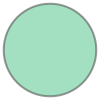

In [6]:
geoms[0]

#### Make some empty lists for holding data

In [7]:
# Make an empty final habitat/non-habitat stats list
statslst = []
statcols = ['BufferDist','nCellsHab',
        'nCellsNon','nCells',
        'PropHab','PropNonHab']

# Make an empty list of non-overlapping buffers
nonlst = []
noncols = ['OccID','OrigIndex','BufferDist']


### Loop over each point buffer and mask the species habitat raster <a name="code63"></a>

In [8]:
# Loop over each point buffer to mask the species habitat raster
print('  Masking species habitat map with each point buffer ....')
for i in gdfPtBuffs.index:

    # Select a single point buffer from an index value in dataframe geometries
    buff = [mapping(geoms[i])]

    # Get the buffer distance value
    dist = gdfPtBuffs.at[i,'buff_dist']

    try:

        # Mask with the species habitat map raster
        with rasterio.open(HabMap) as habras:
            mask_arr, mask_transform = rasterio.mask.mask(habras, buff, crop=True)

        # Get the count of the number of habitat cells: habval variable set above
        cnt1 = len(mask_arr[mask_arr==habval])
        # Get the count of the number of non-habitat cells: in this case = 0
        cnt0 = len(mask_arr[mask_arr==0])
        # Get the total number of cells in the point buffer mask
        ncells = cnt0 +  cnt1
        # Get the proportion of habitat and non-habitat in the point buffer
        propHab = (cnt1/ncells)
        propNon = (cnt0/ncells)
        # Append to the stats list
        statslst.append([dist,cnt1,cnt0,ncells,propHab,propNon])

    except ValueError:
        print('   Buffer does not overlap with species habitat raster')
        # Assemble info on the buffers that did not overlap into a dataframe
        oid = gdfBuffs401.at[i,'occ_id']
        idx = gdfBuffs401.at[i,'index']
        nonlst.append([oid,idx,dist])
        dfNonOverlaps = pd.DataFrame(nonlst, columns=noncols)


  Masking species habitat map with each point buffer ....


### Make the dataframe to run BPA evaluations <a name="code64"></a>

In [9]:
# Make the DataFrame by using the appended raster data list and export to CSV
print("\n\nCreating DataFrame dfHabStats")
dfHabStats = pd.DataFrame(statslst, columns=statcols)

print("\n\n~~~~~~~~~ DONE ~~~~~~~~~~")



Creating DataFrame dfHabStats


~~~~~~~~~ DONE ~~~~~~~~~~


In [10]:
dfHabStats.head(5)

,BufferDist,nCellsHab,nCellsNon,nCells,PropHab,PropNonHab
0,30,4,0,4,1.0,0.0
1,33,0,4,4,0.0,1.0
2,30,0,3,3,0.0,1.0
3,87,0,28,28,0.0,1.0
4,87,0,26,26,0.0,1.0


In [11]:
dfHabStats.tail(10)

,BufferDist,nCellsHab,nCellsNon,nCells,PropHab,PropNonHab
3083,100,0,36,36,0.0,1.0
3084,625,0,1368,1368,0.0,1.0
3085,625,0,1368,1368,0.0,1.0
3086,100,0,36,36,0.0,1.0
3087,100,0,36,36,0.0,1.0
3088,100,0,36,36,0.0,1.0
3089,100,0,36,36,0.0,1.0
3090,625,0,1368,1368,0.0,1.0
3091,100,0,36,36,0.0,1.0
3092,100,0,36,36,0.0,1.0


#### Make empty stats list for BSM plotting

In [12]:
statlst = []
buffcats = [30,100,500,1000,2000,5000,10000]
plotcols = ['BufferCat','TruePos','FalseNeg','Sensitivity','nPts','p-Value']


### Generate the dataframe holding BSM evaluation metrics <a name="code65"></a>

In [13]:
print('\nLooping over 7 buffer distance categories to get sensitivity plot data ...')
# Loop over each buffer distance category to generate data for sensitivity plot
for c in buffcats:
    # Subset the dataframe by buffer distance category
    df = dfHabStats[dfHabStats['BufferDist'] <= c]
    # Calculate buffer category sensitivity stats
    n = len(df)
    if n > 0:
        # Count 'habitat presence' as anything not 0 in hab cell count
        fn = df.loc[df['nCellsHab'] == 0, 'nCellsHab'].count()
        tp = n - fn
        # Count 'habitat presence' using a threshold (prop hab in range)
        #tp = df.loc[df['PropHab'] >= prophab, 'nCellsHab'].count()
        #fn = n - tp
        sens = tp / n
    else:
        tp = 0
        fn = 0
        sens = 0
    # Calculate an exact one-sided binomial test for each buffer distance
    p = stats.binom_test(tp, n=n, p=prophab, alternative='greater')
    if p < 0.0001:
        pv = "< 0.0001"
    else:
        pv = str(round(p,4))
    # Add to the stats list
    statlst.append([c,tp,fn,sens,n,pv])

# Make the final dataframe of the sensitivity stats
dfSens = pd.DataFrame(statlst, columns=plotcols)



Looping over 7 buffer distance categories to get sensitivity plot data ...


In [26]:
dfSens

,BufferCat,TruePos,FalseNeg,Sensitivity,nPts,p-Value
0,30,238,845,0.219760,1083,< 0.0001
1,100,330,1161,0.221328,1491,< 0.0001
2,500,556,1523,0.267436,2079,< 0.0001
3,1000,610,1637,0.271473,2247,< 0.0001
4,2000,926,1717,0.350359,2643,< 0.0001
5,5000,1003,1781,0.360273,2784,< 0.0001
6,10000,1250,1843,0.404138,3093,< 0.0001


### Plot Buffer Proportion Assessment (BPA) graphic <a name="code66"></a><a name="BPA"></a>



 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> BPA and BSM PLOTS <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


<ErrorbarContainer object of 3 artists>

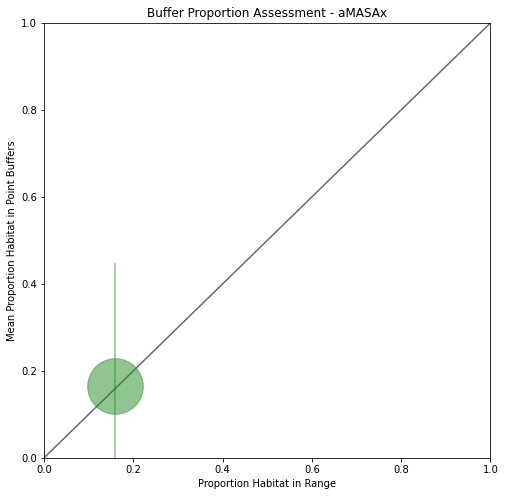

In [15]:
#################################### Start plotting BPA #######################################################
print('\n\n','>'*35, 'BPA and BSM PLOTS', '<'*35)
# Get the mean proportion of habitat in point buffers and its standard deviation
pbmean = round(dfHabStats['PropHab'].mean(),3)
pbsd = round(dfHabStats['PropHab'].std(),3)
nRecs = len(dfHabStats)

#colors = np.random.rand()

fig, ax = plt.subplots(figsize=(8,8))
# Set axes limits and labels
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("Proportion Habitat in Range")
ax.set_ylabel("Mean Proportion Habitat in Point Buffers")
ax.set_title('Buffer Proportion Assessment - {0}'.format(sppcode))

# Draw a y=x line to illustrate 'better than random'
# and 'worse than random' parts of the plot
ax.plot([0,1],[0,1], transform=ax.transAxes, c='dimgray')
# Plot prop. hab in range on x and mean prop. hab in buffers on y
# and a standard deviation 'error' line
# Use the number of records for the species for the marker size
#ax.scatter(prophab, pbmean, s=nRecs, c=colors, alpha=0.5)
ax.errorbar(prophab, pbmean, yerr=pbsd, marker='o', c='forestgreen', ms=math.sqrt(nRecs), alpha=0.5)


### Plot Buffer Sensivity Metric (BSM) graphic <a name="code67"></a><a name="BSM"></a>

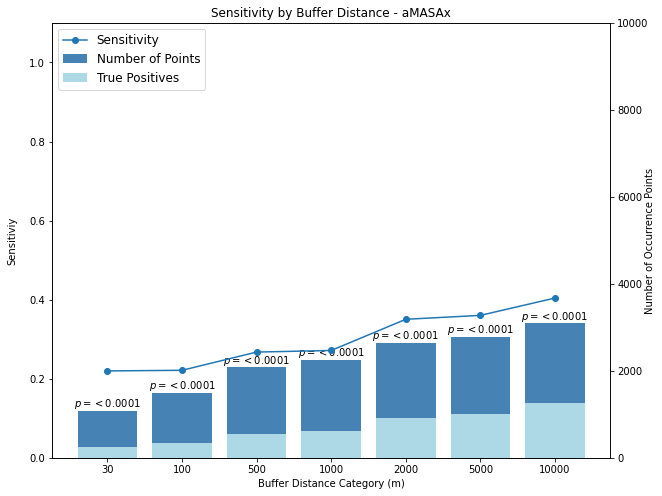

+++++ Processing time was 2:23:12.653585 +++++


In [25]:
#################################### Start plotting BSM #######################################################

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
# Get the maximum number of occurrence points to set the right y limit in plot
nmax = dfSens['nPts'].max()
ymax = 10**(int(np.log10(nmax))+1)
# Set data and parameters for each set of axes NOTE: axis 2 draws last i.e. on top
ln = ax2.plot(dfSens['BufferCat'].astype(str), dfSens['Sensitivity'], marker='o', label='Sensitivity')
br = ax1.bar(dfSens['BufferCat'].astype(str), dfSens['nPts'], color='steelblue', label='Number of Points')
br2 = ax1.bar(dfSens['BufferCat'].astype(str), dfSens['TruePos'], color='lightblue', label='True Positives')
ax2.yaxis.tick_left()
ax1.yaxis.tick_right()

ax2.set_ylim(0,1.1)
ax1.set_ylim(0,ymax)

ax1.set_xlabel("Buffer Distance Category (m)")
ax1.set_ylabel("Sensitiviy",labelpad=35)
ax2.set_ylabel("Number of Occurrence Points",labelpad=35)
ax1.set_title('Sensitivity by Buffer Distance - {0}'.format(sppcode))
# Make a single legend for both axes plots
lb = ln+[br]+[br2]
labs = [l.get_label() for l in lb]
ax2.legend(lb, labs, loc='upper left', fontsize=12)
bars, labels = ax1.get_legend_handles_labels()

# Define a function that will insert p-values above each bar of buffer categories
# The p-values are taken from the dfSens dataframe and represent a test of
# significance using an exact one-sided binomial test of number of TPs and
# total number of points used in each buffer category
def plabel(a, rects, pvalue, xpos='center'):
    """
    Attach a text label above each bar.

    *xpos* indicates which side to place the text with respect to
    the center of the bar. It can be one of the following:
    {'center', 'right', 'left'}.
    
    parameters:
    a = matplotlib axis to plot on
    rects = the rectangles representing the bars in the chart
    pvalue = the label values to insert
    xpos = center, right, left postion
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for i, rect in enumerate(rects):
        height = rect.get_height()
        a.text(rect.get_x() + rect.get_width()*offset[xpos], 1.0*height,
                r'$p = {}$'.format(pvalue[i]), ha=ha[xpos], va='bottom')

pvals = dfSens['p-Value']
plabel(ax1,br,pvals,'center')

plt.show()

t1 = datetime.now()
print("+++++ Processing time was", t1 - t0, '+++++')


### Discussion <a name="discussion"></a>

In [22]:
pvals

0    < 0.0001
1    < 0.0001
2    < 0.0001
3    < 0.0001
4    < 0.0001
5    < 0.0001
6    < 0.0001
Name: p-Value, dtype: object

**Table 1**

Tests for richness concordance between four vertebrate taxa in the conterminous United States based on total number of species attributed to 12-digit Hydrologic Units (HUCs) (n=82717). Kendall’s rank correlation coefficients $\tau$ for pairwise comparisons among taxa and between each taxon and the overall richness index (calculated using Spearman’s $\rho$).

| Taxon                  | Amphibians |  Birds | Mammals | Reptiles |
|------------------------|:----------:|:------:|:-------:|:--------:|
| Amphibians ($\tau$)    |      1     |        |         |          |
| Birds ($\tau$)         |   0.0139   |    1   |         |          |
| Mammals ($\tau$)       |   -0.3114  | 0.2859 |    1    |          |
| Reptiles ($\tau$)      |   0.4582   | 0.1022 | -0.1316 |     1    |
| Overall Index ($\rho$) |   0.3248   | 0.2903 | -0.1329 |  0.4192  |


---
Most comparisons reveal little in the way of overlap between taxa richness at the HUC scale, with four of the six pairwise comparisons having correlation coefficients below ±0.3. Modest relationships exist between mammals and amphibians and between reptiles and amphibians ($\tau$ = -0.3114 and 0.4582 respectively). Overall, reptiles exhibit the strongest measure of overlap in richness between all other groups ($\rho$ = 0.4192).


**Comparisons with other similar studies**

Correlations between taxon richness and overall richness (measured by Spearman's $\rho$ coefficient) are remarkably similar to values reported by Hess et al. (2006) at their smallest grain of analysis (315,000 km<sup>2</sup> hexagons) for the Mid-Atlantic region of the US. They reported amphibians and reptiles as having the highest measure of concordance with all other taxa ($\rho$ = 0.47 and 0.33 respectively) and likewise identified mammals as exhibiting a negative relationship with overall taxa richness ($\rho$ = -0.12). However, Hess et al. (2006) did not observe similar relationships for those taxa in their Pacific Northwest region of analysis (states of Oregon and Washington). It may be possible that the more biodiverse eastern US could drive patterns of species richness throughout CONUS, particularly as it relates to amphibians and reptiles (see McKerrow et al. 2018 for a discussion of species richness hotspots in the US).

Similarly, Ricketts et al. (1999) found amphibians and reptiles to have the highest measures of richness concordance with all other taxa, albeit at much higher levels across all groups. Their analyses were conducted across the entiretly of northern North America (CONUS and Canada) and for 9 species groups including invertebrates and vascular plants. The grain of the Ricketts et al. (1999) study was terrestrial ecoregions developed by the World Wildlife Fund. Theses ecoregions vary widely in both size and extent. Although Ricketts et al. (1999) conclude that any the taxa they tested could be effective indicators of overall species richness, they caution such an assessment may only be reliable at coarse scales. The analyses conducted in this notebook are at a much finer grain than ecoregions (or Hess et al.'s hexagons) and suggest that richness patterns across taxa groups are not a nested phenomenon.


## Citations <a name="citations"></a>

Anderson, R.P., M. Gomez-Laverde, and A.T. Peterson. (2002). Geographical distributions of spiny pocket mice in South America: Insights from predictive models. Global Ecology and Biogeography 11, 131-141.  https://doi.org/10.1046/j.1466-822X.2002.00275.x.

McKerrow A.J., N.M. Tarr M.J. Rubino and S.G. Williams. (2018). Patterns of species richness hotspots and estimates of their protection are sensitive to spatial resolution. Diversity and Distributions 24:1461-1477. https://doi.org/10.1111/ddi.12779.

Pearson, R.G. (2007). Species’ distribution modeling for conservation educators and practitioners. Available at: http://biodiversityinformatics.amnh.org.

Rondinini, C., Di Marco, M., Chiozza, F., Santulli, G., Baisero, D., Visconti, P., ... Boitani, L. (2011). Global habitat suitability models of terrestrial mammals. Philosophical Transaction of the Royal Society B: Biological Sciences, 366, 2633-2641. https://doi.org/10.1098/rstb.2011.0113.